In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# Load background
background_image_path = '/content/gdrive/My Drive/Ray Tracing Project/sightpy/backgrounds/lake.png'
background_image = Image.open(background_image_path)
background_image = np.array(background_image) / 255.0

def get_background_color(ray_direction, cube_map):
    direction = ray_direction / np.linalg.norm(ray_direction)
    abs_direction = np.abs(direction)
    major_axis = np.argmax(abs_direction)
    face_dir = np.sign(ray_direction[major_axis])
    u = v = 0
    face_row = 1
    if major_axis == 1:
        face_row = 0 if face_dir > 0 else 2
    face_width = cube_map.shape[1] / 4
    face_height = cube_map.shape[0] / 3
    if major_axis == 0:
        u = (direction[2] / direction[0] + 1) / 2.0
        v = (1.0 - direction[1] / direction[0]) / 2.0
        face_col = 1 if face_dir > 0 else 3
        v = 1.0 - v if face_dir < 0 else v
        u = 1.0 - u if face_dir > 0 else u
    elif major_axis == 1:
        u = (direction[0] / direction[1] + 1) / 2.0
        v = (direction[2] / direction[1] + 1) / 2.0
        face_col = 1
        (u, v) = (v, u) if face_dir > 0 else (u, v)
        u = 1.0 - u if face_dir > 0 else u
    elif major_axis == 2:
        u = (direction[0] / direction[2] + 1) / 2.0
        v = (1.0 - direction[1] / direction[2]) / 2.0
        face_col = 0 if face_dir > 0 else 2
        v = 1.0 - v if face_dir < 0 else v
        u = 1.0 - u if face_dir > 0 else u
    pixel_x = int(face_col * face_width + u * face_width) % cube_map.shape[1]
    pixel_y = int(face_row * face_height + v * face_height) % cube_map.shape[0]
    color = cube_map[pixel_y, pixel_x]
    luminance_scale = 2.0
    return color * luminance_scale

class Material:
    def __init__(self, color, reflective=0, emissive=False):
        self.color = np.array(color)
        self.reflective = reflective
        # Emissive is now a boolean indicating if the material is a light source
        self.emissive = emissive

    def is_emissive(self):
        # Return the emissive status
        return self.emissive



class Sphere:
    def __init__(self, center, radius, material):
        self.center = np.array(center)
        self.radius = radius
        self.material = material

    def intersect(self, ray):
        L = self.center - ray.origin
        tca = np.dot(L, ray.direction)
        d2 = np.dot(L, L) - tca * tca
        if d2 > self.radius ** 2:
            return float('inf'), None
        thc = np.sqrt(self.radius ** 2 - d2)
        t0 = tca - thc
        t1 = tca + thc
        if t0 < 0 and t1 < 0:
            return float('inf'), None
        if t0 < 0:
            return t1, self
        return t0, self



class Ray:
    def __init__(self, origin, direction):
        self.origin = np.array(origin)
        self.direction = np.array(direction)
        self.direction /= np.linalg.norm(self.direction)

class Scene:
    def __init__(self):
        self.objects = []

    def add_object(self, obj):
        self.objects.append(obj)

def trace_ray(ray, scene, depth, max_depth=3, intensity=1.0):
    if depth > max_depth or intensity < 0.05:
        return np.array([0.0, 0.0, 0.0], dtype=np.float64)

    closest_dist = float('inf')
    closest_obj = None
    for obj in scene.objects:
        dist, obj_hit = obj.intersect(ray)
        if dist != float('inf') and dist < closest_dist:
            closest_dist = dist
            closest_obj = obj_hit

    if closest_obj is None:
        return get_background_color(ray.direction, background_image) * intensity

    hit_point = ray.origin + ray.direction * closest_dist
    normal = normalize(hit_point - closest_obj.center)

    if closest_obj.material.is_emissive():
        # If the material is emissive, return its color as the light intensity
        return closest_obj.material.color * intensity

    color = np.array([0.0, 0.0, 0.0], dtype=np.float64)

    if closest_obj.material.reflective > 0:
        reflective_direction = reflect(ray.direction, normal)
        reflective_ray = Ray(hit_point + reflective_direction * 0.001, reflective_direction)
        reflected_color = trace_ray(reflective_ray, scene, depth + 1, max_depth, intensity * closest_obj.material.reflective)
        color += reflected_color

    random_direction = random_in_hemisphere(normal)
    random_ray = Ray(hit_point + random_direction * 0.001, random_direction)
    diffuse_color = trace_ray(random_ray, scene, depth + 1, max_depth, intensity * (1 - closest_obj.material.reflective))
    color += closest_obj.material.color * diffuse_color

    return np.clip(color, 0, 1)



def random_in_hemisphere(normal):
    phi = 2 * np.pi * np.random.rand()
    cos_theta = np.random.rand()
    sin_theta = np.sqrt(1 - cos_theta * cos_theta)
    x = sin_theta * np.cos(phi)
    y = sin_theta * np.sin(phi)
    z = cos_theta
    u = np.cross([0, 1, 0], normal) if abs(normal[0]) > abs(normal[2]) else np.cross([1, 0, 0], normal)
    u = u / np.linalg.norm(u)
    v = np.cross(normal, u)
    direction = x * u + y * v + z * normal
    return direction

def reflect(direction, normal):
    return direction - 2 * np.dot(direction, normal) * normal

def scatter_ray(normal, incoming_direction, reflectiveness):
    if np.random.rand() < reflectiveness:
        # Reflect ray
        return reflect(-incoming_direction, normal)
    else:
        # Scatter ray
        return random_in_hemisphere(normal)


def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
       return v
    return v / norm

def render(scene, camera, width, height, samples_per_pixel=50):
    image = np.zeros((height, width, 3))
    for i in tqdm(range(height), desc='Rendering'):  # Add tqdm here for progress bar
        for j in range(width):
            pixel_color = np.zeros(3)
            for s in range(samples_per_pixel):
                x = (2 * (j + random.random()) / width - 1) * np.tan(np.pi / 8) * width / height
                y = -(2 * (i + random.random()) / height - 1) * np.tan(np.pi / 8)
                ray = Ray(camera, [x, y, 1])
                pixel_color += trace_ray(ray, scene, 0)
            image[i, j] = np.clip(pixel_color / samples_per_pixel, 0, 1)
    return image



Rendering: 100%|██████████| 480/480 [23:44<00:00,  2.97s/it]


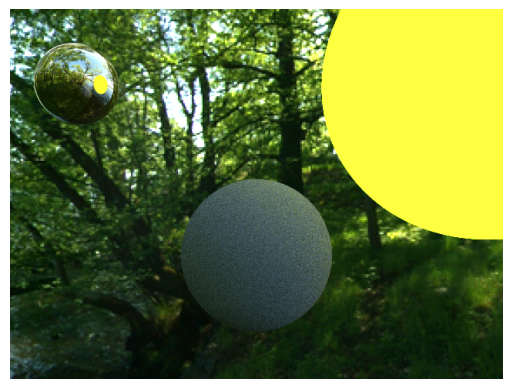

In [ ]:
# The spherical scene

# width, height = 360, 240
# width, height = 200, 150
width, height = 640, 480
camera = [0, 0, 0]  # Camera position
scene = Scene()


emissive = Material((2.42, 3.78, 0.26), 0.0, True)
rough = Material([0.6, 0.6, 0.9], 0.02, False)
reflective = Material([0.7, 0.3, 0], 0.8, False)

scene.add_object(Sphere([0, -0.4, 3], 0.5, rough))
scene.add_object(Sphere([2, 1, 4], 1.4, emissive))
scene.add_object(Sphere([-1.8, 1.1, 4.5], 0.4, reflective))

image = render(scene, camera, width, height)

plt.imshow(image)
plt.axis('off')
plt.show()

